# $$\textbf{Python Programming for Machine Learning} $$ 

#### $$\text{WiSe 2020/2021}$$

## $$\text{Lecture 4: Markov chains, Optimization} $$
## $$\text{Cython, Numba}$$

#### $$\text{Sergej Dogadov} \quad \text{Philine Thalia Görzig} \quad \text{Panagiotis Tomer Karagiannis}$$

<center>
<img src='images/pyt.png' width=450>

## $$\textbf{Markov chains}$$
<hr>

* $\text{A Markov chain transits between a set of states, where the transition between pairs of states is associated with a fixed probability.}$

<br>

* $\text{The set of probabilities can be stored in a transition matrix.}$

<center>
    <img src='./images/markov.png', width='1200'>

In [3]:
import numpy as np

# Transition matrix

T = np.array([
    [0.9,0.1,0.0], # transiting from state 1 to state 1,2,3
    [0.0,0.9,0.1], # transiting from state 2 to state 1,2,3
    [1.0,0.0,0.0], # transiting from state 3 to state 1,2,3
])

## $$\textbf{ Transition matrix and initial states}$$
<hr> 

In [197]:
# Add empty state to transition matrix

pad_shape = ((0, 0), (1, 0))  # ((before_1, after_1), (before_2, after_2))

P = np.pad(T, pad_shape, mode='constant') # diff modes available like: mean, empty, func, etc
print(P)

[[0.  0.9 0.1 0. ]
 [0.  0.  0.9 0.1]
 [0.  1.  0.  0. ]]


In [198]:
# Init tokens to start at the same node 0
num_tokens = 5
starting_constellation = [1, 0, 0]

# explicit repetition
#X = np.tile(starting_constellation, reps=(num_tokens,1)) 

# implicit by broadcasting:

X = np.outer(5*[1], starting_constellation) # (5,) x (3,) -> (5,3)
X

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

## $$\textbf{ Markov chain step }$$
<hr> 

In [204]:
def mc_step(X, P):
    
    Xp = np.dot(X, P) # one mc step
    #print('Xp\n', Xp)
    
    Xc = np.cumsum(Xp, axis=1)
    #print(50*'='+f'\nXc\n{Xc}')
    
    L, H = Xc[:, :-1], Xc[:, 1:]
    
    R = np.random.uniform(0, 1, (Xp.shape[0], 1)) # random state for each token
    #print(R)
    states = (R >= L) * (R < H) #equiv: np.logical_and((R > L), (R < H))
    
    #print(states.astype('int32'))
    return states.astype('int32')

mc_step(X,P)

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=int32)

## $$\textbf{ Simulate Markov process}$$
<hr> 

In [215]:

def simulate(X, P, num_steps=50000, verbose=False):

    for i in range(num_steps):
        
        X = mc_step(X, P)
        
        if verbose:
            print(str(X)+'\n')

    return X.mean(axis=0) # represents a prob of token to in one of the Markov chain states

In [226]:
simulate(X, P, num_steps=3, verbose=False)

array([0.6, 0.4, 0. ])

In [211]:
simulate(X, P)

array([0.6, 0.4, 0. ])

# $$\textbf{ Optimization}$$
<hr>

<center>
    <img src='./images/optim.png' width='600'>

# $$\textbf{ Automatic differentiation with JAX}$$
<hr> 

<center>
    <img src='./images/JAX.png' width='400'>

In [227]:
#conda install -c conda-forge jax

import jax.numpy as np 
from jax import grad

## $$\textbf{ Taking univariate function derivatives}$$
<hr> 


$$y = 3 x^2 + 2, \quad y^{'}_{x} = 6x, \quad y^{''}_{x} = 6$$

In [232]:
# define a function to numerically comp a gradient for
import jax.numpy as np

def y(x):
    return 3 * np.square(x) + 2 # note you are using jax numpy

# grad comp at the point
x0 = 10.   # has to be float no diff possible on integers

# first derivative
print(grad(y)(x0)) # evaluated at point x

# second
print(grad(grad(y))(100*x0))

60.0
6.0


## $$\textbf{ Multivariate function derivatives}$$
<hr> 
<br>
<center>
$y = 3 x_1^3 + 2^{x_2}, \quad \frac{\partial y}{\partial x_1} = 9 x_1^2  \quad  \frac{ \partial y}{\partial x_2} = 2^{x_2} \ln{2}$

In [45]:
x1 = 2. # has to be float
x2 = 3. # has to be float

y = lambda x1, x2 : 3*np.power(x1,3) + np.power(2,x2) # note you are using jax numpy

# wrt x_1 (first func arg)
val = grad(y, 0)(x1,x2) # 9 * 2**2 = 36

test_val = 9*x1**2
print(f'{val} == {test_val}')

assert np.isclose(val,test_val)

# wrt x_2
val = grad(y, 1)(x1, x2) # 2**(3)*ln(2)

test_val = 2**x2*np.log(2)
print(f'{val} == {test_val}')

assert np.isclose(val, test_val, atol=1e-8) # 0.001 10**-3

36.0 == 36.0
5.545177459716797 == 5.545177459716797


* $\text{For more info about}\>$ <a href='https://jax.readthedocs.io/en/latest/notebooks/quickstart.html'>JAX</a>



## $$\textbf{ Gradient descent for finding minimum of a function}$$
<hr> 
<br>
$$y = kx^2, \quad k=3$$

In [255]:
# a function to find a minimum numerically
import jax.numpy as np 

y = lambda x, coeff=3: coeff*np.power(x, 2) # jax numpy !

def minimize(fn, x0=0, step_size=0.1, max_it=5): 

    xs = np.array([x0]).astype(np.float32) # list of the checked points

    for it in range(max_it):
        
        grad_f = grad(fn)
        
        curr_val = xs[-1]
        if abs(grad_f(curr_val)) > 1e-2: # the derivative approx not zero
            
            next_val = curr_val - step_size*grad_f(curr_val)
            xs = np.append(xs, next_val)
            
        else:
            return xs
            
    return xs

In [256]:
xs = minimize(y, x0=-5., step_size=0.01)
xs[:10]

DeviceArray([-5.       , -4.7      , -4.4179997, -4.15292  , -3.9037447,
             -3.66952  ], dtype=float32)

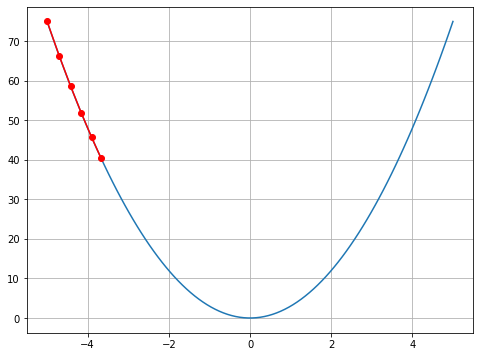

In [257]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-5, 5, 100)

plt.figure(figsize=(8,6))
plt.plot(x, y(x))
plt.grid()
plt.plot(xs, y(xs), "-o", c="r");

In [264]:
from scipy.optimize import minimize
import numpy as np

y = lambda x, coeff=3, offset=2: coeff*np.power(x, 2) + offset 

res = minimize(y, -5, args=(2, 0))

res

      fun: 1.2944441289221764e-15
 hess_inv: array([[0.25]])
      jac: array([-7.19599154e-08])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([-2.54405594e-08])

## $$\textbf{Making pure Python faster by yourself}$$
<hr> 

In [265]:
import math

def is_prime(num):
    
    if num == 2:
        return True
    
    if num <= 1 or not num % 2:
        return False
    
    for div in range(3, int(math.sqrt(num)) + 1, 2):
        if not num % div:
            return False
        
    return True
    

In [266]:
def check_numbers(max_num, verbose=True):
    
    for num in range(0, max_num):
        res = is_prime(num)
        if verbose:
            print(num, res)

In [177]:
check_numbers(10)

0 False
1 False
2 True
3 True
4 False
5 True
6 False
7 True
8 False
9 False


## $$\textbf{Benchmarking function}$$

In [271]:
from time import time

def benchmark(fn, args=()):
    st = time()
    fn(*args)
    return f'Elapsed time: {(time() - st):0.6f}'

In [272]:
benchmark(check_numbers, args=(1000000, False))

'Elapsed time: 2.382982'

## $$\textbf{A high performance Python compiler}$$
<hr>
<br><br>

<center>
    <img src='./images/numba.png' width='400'>

* $\text{Add an automatic compiler}$

In [277]:
# conda -c conda-forge numba

from numba import njit, prange

@njit(fastmath=True)
def is_prime(num):
    
    if num == 2:
        return True
    
    if num <= 1 or not num % 2:
        return False
    
    for div in range(3, int(math.sqrt(num)) + 1, 2):
        if not num % div:
            return False
        
    return True

In [278]:
@njit(fastmath=True)
def check_numbers(max_num):
    
    for num in range(max_num):
        res = is_prime(num)

In [279]:
benchmark(check_numbers, args=(1000000, ))

'Elapsed time: 0.610691'

## $$\textbf{ Cython}$$
<hr> 

* $\text{Cython is a static compiler for Python programming language}$
<br><br>
<center>
    <img src='./images/cython.png' width='300'>

In [280]:
# conda install -c anaconda cython

import cython

%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [295]:
%%cython -a

#cython: boundscheck=False, wraparound=False, cdivision=True, nonecheck=False

import numpy as np
cimport numpy as np
cimport cython

cdef float[:,:] fill_(int n, float fill_value):
    
    cdef:
        int i
        float[:,:] outs = np.empty((n,n), dtype = np.float32)
    
    for i in range(n):
        for j in range(n):   
            outs[i,j] = fill_value

    return outs


cpdef np.ndarray cdot(float[:,:] X, float[:,:] Y): 
    
    n = len(X)
    cdef:
        int i,j
        float[:,:] Z = fill_(n, 0.)    
    

    for i in range(n):
        for j in range(n):
            for k in range(n):
                Z[i,j] += X[i, k] * Y[k, j]
    
    return np.array(Z)

## $$\textbf{ Measure the performance }$$
<hr> 

In [286]:
n = 500
X = np.random.normal(0,1, size=(n,n)).astype(np.float32)
X.shape, X.dtype

benchmark(cdot, args=(X,X))

'Elapsed time: 0.156002'

In [287]:
%timeit -n 10 -r 3 cdot(X,X)

188 ms ± 1.08 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [288]:
fn = lambda X: X @ X 

In [289]:
%timeit -n 10 -r 3 fn(X)

1.84 ms ± 219 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
